## Import das bibliotecas utilizadas


In [12]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import multimode
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from prophet.diagnostics import performance_metrics



### Carregamento dos dados para a parte de Análise das métricas

In [13]:
metrics_prophet = pd.read_csv(r'../../Projeto/Data/Metrics/metrics_prophet.csv')
metrics_hw = pd.read_csv(r'../../Projeto/Data/Metrics/metrics_hw.csv')
metrics_pred_simple_exp_smoot = pd.read_csv(r'../../Projeto/Data/Metrics/metrics_pred_simple_exp_smoot.csv')
metrics_predictions_sarimax_exog = pd.read_csv(r'../../Projeto/Data/Metrics/metrics_predictions_sarimax_exog.csv')
metrics_predictions_sarimax_no_exog = pd.read_csv(r'../../Projeto/Data/Metrics/metrics_predictions_sarimax_no_exog.csv')
metrics_predictions_autoarima = pd.read_csv(r'../../Projeto/Data/Metrics/metrics_predictions_autoarima.csv')


In [31]:
df_transposed_copy_inputting_v19 = pd.read_csv(r'../../Projeto/Data/Output/df_transposed_copy_inputting_v19.csv')
df_model = df_transposed_copy_inputting_v19.copy()
df_model['year'] = pd.to_datetime(df_model['year'], format='ISO8601')
df_model.set_index('year', inplace = True)
df_model.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49 entries, 1980-01-01 to 2028-01-01
Columns: 228 entries, Afghanistan to World
dtypes: float64(228)
memory usage: 87.7 KB


## Análise de métricas vs modelos

As métricas MAE (Erro Absoluto Médio), RMSE (Raiz do Erro Quadrático Médio) e MAPE (Erro Percentual Absoluto Médio) são importantes para avaliar o desempenho de um modelo de ciência de dados. Elas medem a diferença entre os valores previstos pelo modelo e os valores reais observados. <br/><br/> - O MAE mede a magnitude média dos erros, enquanto o RMSE dá mais peso aos erros grandes, pois eleva ao quadrado as diferenças antes de calcular a média. <br/><br/> - O MAPE mede o erro em termos percentuais, o que pode ser útil quando os valores observados variam em magnitude. <br/><br/> Ao comparar diferentes modelos, é importante escolher aquele que apresenta o menor valor para essas métricas, indicando que suas previsões são mais precisas.

A média, a mediana e o desvio padrão são medidas estatísticas que podem ser usadas para analisar um conjunto de dados. <br/><br/>
 - A média é a soma de todos os valores dividida pelo número de valores e representa o valor central do conjunto de dados. 
 - A mediana é o valor que divide o conjunto de dados em duas metades iguais, ou seja, metade dos valores estão acima da mediana e metade estão abaixo.
 - O desvio padrão mede o quanto os valores do conjunto de dados se desviam da média. Um desvio padrão alto indica que os valores estão mais dispersos, enquanto um desvio padrão baixo indica que os valores estão mais proximos da média. 


### Análise pela métrica MAE

O MAE (Erro Absoluto Médio) é uma métrica comum para avaliação de desempenho de modelos de previsão de séries temporais. O MAE mede a magnitude média dos erros (magnitude do erro é uma medida da diferença entre os valores previstos por um modelo e os valores reais observados, seu valor indica o queão precisa foi a previsão.)


 - Média: Um modelo com um valor menor de MAE médio é considerado melhor, pois suas previsões são mais precisas.
 - Mediana: A mediana do MAE é uma medida mais robusta a outliers, pois não é afetada por valores extremos.
 - Desvio padrão: Um modelo com desvio padrão baixo para o MAE é considerado mais consistente, pois seus erros de previsão são mais próximos da média. 

In [15]:
final_metrics = pd.DataFrame()
metric = 'MAE'

statistics = [
    'mean',
    'median',
    'std',
    'min',
    'max',
]
final_metrics = pd.concat([final_metrics, metrics_prophet[metric].agg(statistics)], axis=1)

# add simples smothing
final_metrics = pd.concat([final_metrics, metrics_pred_simple_exp_smoot[metric].agg([statistics])], axis=1)

# add sarimax
final_metrics = pd.concat([final_metrics, metrics_predictions_sarimax_exog[metric].agg([statistics])], axis=1)
# add sarimax non exog
final_metrics = pd.concat([final_metrics, metrics_predictions_sarimax_no_exog[metric].agg([statistics])], axis=1)
# add autoarima
final_metrics = pd.concat([final_metrics, metrics_predictions_autoarima[metric].agg([statistics])], axis=1)
# add hw
final_metrics = pd.concat([final_metrics, metrics_hw[metric].agg([statistics])], axis=1)

final_metrics.columns = ['prophet','simple_smoothing','sarimax', 'sarimax no exog', 'autoarima', 'Holt-Winters']

final_metrics = final_metrics.T

final_metrics['cv'] = final_metrics['std'] /final_metrics['mean']  
final_metrics.style.highlight_min(color='lightgreen', axis=0)

,mean,median,std,min,max,cv
prophet,1.672544,0.965000,1.991240,0.130000,18.670000,1.190546
simple_smoothing,1.574254,1.130000,1.900460,0.070000,18.420000,1.207213
sarimax,1.534781,1.070000,1.674111,0.220000,15.530000,1.090782
sarimax no exog,1.534781,1.070000,1.674111,0.220000,15.530000,1.090782
autoarima,2.098202,1.630000,1.872705,0.140000,16.760000,0.892529
Holt-Winters,1.659518,1.360000,1.853458,0.180000,18.170000,1.116865


Pela métrica MAE os modelos que melhor performaram foram os SARIMAX (com e sem variável exógena)

### Avaliação pela métrica MAPE

O MAPE (Erro percentual absoluto médio) é também uma métrica comum para avaliar o desempenho dos modelos de previsão de séries temporais. O MAPE mede o erro em termos percentuais.


 - Média: Um modelo com um valor menor de MAPE médio é considerado melhor, pois suas previsões são mais precisas.
 - Mediana: A mediana do MAPE é uma medida mais robusta a outliers, pois não é afetada por valores extremos.
 - Desvio padrão: Um modelo com desvio padrão baixo para o MAPE é considerado mais consistente, pois seus erros de previsão são mais próximos da média. 

In [16]:
final_metrics = pd.DataFrame()
metric = 'MAPE'

statistics = [
    'mean',
    'median',
    'std',
    'min',
    'max',
]
final_metrics = pd.concat([final_metrics, metrics_prophet[metric].agg(statistics)], axis=1)

# add simples smothing
final_metrics = pd.concat([final_metrics, metrics_pred_simple_exp_smoot[metric].agg([statistics])], axis=1)

# add sarimax
final_metrics = pd.concat([final_metrics, metrics_predictions_sarimax_exog[metric].agg([statistics])], axis=1)
# add sarimax non exog
final_metrics = pd.concat([final_metrics, metrics_predictions_sarimax_no_exog[metric].agg([statistics])], axis=1)
# add autoarima
final_metrics = pd.concat([final_metrics, metrics_predictions_autoarima[metric].agg([statistics])], axis=1)
# add hw
final_metrics = pd.concat([final_metrics, metrics_hw[metric].agg([statistics])], axis=1)

final_metrics.columns = ['prophet','simple_smoothing','sarimax', 'sarimax no exog', 'autoarima', 'Holt-Winters']

final_metrics = final_metrics.T

final_metrics['cv'] = final_metrics['std'] /final_metrics['mean']  
final_metrics.style.highlight_min(color='lightgreen', axis=0)

,mean,median,std,min,max,cv
prophet,65.165499,32.221438,137.931462,2.306472,1776.535147,2.116633
simple_smoothing,inf,38.778678,nan,2.168885,inf,nan
sarimax,55.824796,34.970081,101.852378,6.796140,1251.420640,1.824501
sarimax no exog,55.824796,34.970081,101.852378,6.796140,1251.420640,1.824501
autoarima,56.938106,51.854980,49.667745,7.408767,624.253914,0.872311
Holt-Winters,inf,39.797832,nan,4.955530,inf,nan


Para o MAPE o modelo que melhor performou foi o autoarima, apesar do SARIMAX obter a melhor média.

### Avaliação pelo método RMSE

O RMSE (Raiz do Erro Quadrático Médio) é uma métrica comum para avaliar o desempenho de modelos de previsão. Ele mede a diferença entre os valores previstos pelo modelo e os valores reais observados, elevando ao quadrado as diferenças antes de calcular a média e, em seguida, tirando a raiz quadrada do resultado. Isso dá mais peso aos erros grandes, pois eles são elevados ao quadrado antes de serem somados. O RMSE é útil quando se deseja penalizar erros grandes e pode ser usado para comparar o desempenho de diferentes modelos. Um modelo com um valor menor de RMSE é considerado melhor, pois suas previsões são mais precisas.


 - Média: Um modelo com um valor menor de RMSE médio é considerado melhor, pois suas previsões são mais precisas.
 - Mediana: A mediana do RMSE é uma medida mais robusta a outliers, pois não é afetada por valores extremos.
 - Desvio padrão: Um modelo com desvio padrão baixo para o RMSE é considerado mais consistente, pois seus erros de previsão são mais próximos da média. 

In [17]:
final_metrics = pd.DataFrame()
metric = 'RMSE'

statistics = [
    'mean',
    'median',
    'std',
    'min',
    'max',
]
final_metrics = pd.concat([final_metrics, metrics_prophet[metric].agg(statistics)], axis=1)

# add simples smothing
final_metrics = pd.concat([final_metrics, metrics_pred_simple_exp_smoot[metric].agg([statistics])], axis=1)

# add sarimax
final_metrics = pd.concat([final_metrics, metrics_predictions_sarimax_exog[metric].agg([statistics])], axis=1)
# add sarimax non exog
final_metrics = pd.concat([final_metrics, metrics_predictions_sarimax_no_exog[metric].agg([statistics])], axis=1)
# add autoarima
final_metrics = pd.concat([final_metrics, metrics_predictions_autoarima[metric].agg([statistics])], axis=1)
# add hw
final_metrics = pd.concat([final_metrics, metrics_hw[metric].agg([statistics])], axis=1)

final_metrics.columns = ['prophet','simple_smoothing','sarimax', 'sarimax no exog', 'autoarima', 'Holt-Winters']

final_metrics = final_metrics.T

final_metrics['cv'] = final_metrics['std'] /final_metrics['mean']  
final_metrics.style.highlight_min(color='lightgreen', axis=0)

,mean,median,std,min,max,cv
prophet,1.822105,1.080000,2.125825,0.140000,19.080000,1.166686
simple_smoothing,1.792237,1.225000,2.618678,0.080000,26.040000,1.461123
sarimax,1.715263,1.175000,2.144695,0.340000,24.160000,1.250359
sarimax no exog,1.715263,1.175000,2.144695,0.340000,24.160000,1.250359
autoarima,2.255132,1.690000,2.284594,0.190000,24.850000,1.013064
Holt-Winters,1.888246,1.470000,2.561355,0.230000,25.670000,1.356474


Com a métrica de RMSE o modelo que melhor performou foi o Prophet

### Cross-Validation

#### SARIMAX

A validação cruzada consiste em dividir o conjunto de dados em partes, ajustar o modelo em uma parte dos dados (chamada de conjunto de treinamento) e avaliar o desempenho do modelo na outra parte dos dados (chamada de conjunto de teste).<br/><br/> Esse processo é repetido várias vezes, com diferentes divisões dos dados, para obter uma estimativa mais precisa do desempenho do modelo. 

In [18]:
test_years = 5
train_data = df_model.iloc[:-test_years, :]
test_data = df_model.iloc[-test_years:, :]


/home/hingryd/Documents/Lighthouse/DS/venv/lib/python3.10/site-packages/pmdarima/arima/_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,1,0)(0,0,0)[0] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/home/hingryd/Documents/Lighthouse/DS/venv/lib/python3.10/site-packages/pmdarima/arima/_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/home/hingryd/Documents/Lighthouse/DS/venv/lib/python3.10/site-packages/pmdarima/arima/arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "/home/hingryd/Documents/Lighthouse/DS/venv/lib/python3.10/site-packages/pmdarima/arima/arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/home/hingryd/Documents/Lighthouse/DS/venv/lib/python3.10/site-packages/pmdarima/arima/arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
  File "/home/hingryd/Documents/Lighthouse/DS

mean mae for all countrys 4.3008509377779545
median mae for all countrys 3.5542098026267004
std mae for all countrys 2.7027640927765826
std mae for all countrys 17.605639979946666
std mae for all countrys 1.2285714285714289
cv mae for all countrys 0.6284254283346478


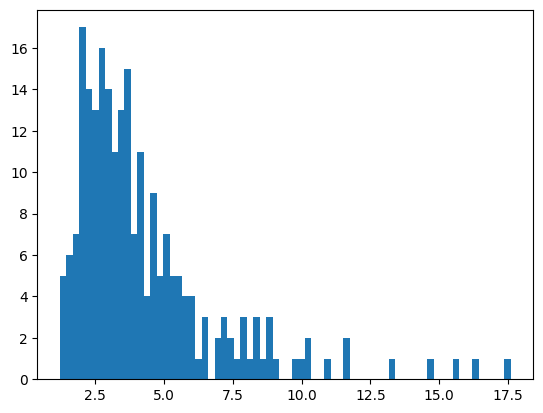

In [19]:
#Create an empty dataframe to store the model metrics
df_final_metrics_cv = pd.DataFrame()

# Defining the number of splits
n_splits = 5

# Create an object TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)

# Inside the loop for cross-validation splits
for country in df_model.columns:
    final_metrics_cv = pd.DataFrame()
    for train_idx, test_idx in tscv.split(train_data[country]):
        train_data_idx = train_data[country].iloc[train_idx]
        test_data_idx = train_data[country].iloc[test_idx]
        model_sarimax = auto_arima(
            train_data_idx,
            m=1,
            test='adf',
            seasonal=True,
            stepwise=True,
            d=1,
            #start_p=0,
            #max_p=1,
            #start_q=0,
            #max_q=1,

        )
        
        pred_sarimax = model_sarimax.predict(n_periods=len(test_data_idx))

        mae = mean_absolute_error(test_data_idx, pred_sarimax)

        final_metrics_cv = pd.concat([final_metrics_cv, pd.DataFrame({country: [mae]})], ignore_index=True)

    df_final_metrics_cv = pd.concat([df_final_metrics_cv, final_metrics_cv], axis=1)
aux = df_final_metrics_cv.mean()

print("mean mae for all countrys",aux.values.mean())
print("median mae for all countrys",np.median(aux.values))
print("std mae for all countrys",aux.values.std())
print("std mae for all countrys",aux.values.max())
print("std mae for all countrys",aux.values.min())
print("cv mae for all countrys",aux.values.std() / aux.values.mean())
plt.hist(aux.values, bins=70);

In [20]:
df_final_metrics_cv.to_csv('../../Projeto/Data/Metrics/df_final_metrics_cv_sarima.csv', index = True)


In [68]:
#MAPE function
def MAPE(df_model_true, df_model_pred):
    df_model_true, df_model_pred = np.array(df_model_true), np.array(df_model_pred)
    return np.mean(np.abs((df_model_true - df_model_pred)/ df_model_true)) *100


In [69]:
metrics_predictions_sarimax_cv = pd.DataFrame()
metrics_results = []
for country in df_model.columns:
    mae = (round(mean_absolute_error(test_data[country], df_final_metrics_cv[country]),2))
    rmse = (round(np.sqrt(mean_squared_error(test_data[country], df_final_metrics_cv[country])),2))
    mape = (MAPE(test_data[country], df_final_metrics_cv[country]))
    #print(f"Country: {country}")
    #print(f"MAE: {mae}")
    #print(f"RMSE: {rmse}")
    #print(f"MAPE: {mape}")
    #print("=============")
    metrics_results.append({
        "Country": country,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape
    })

metrics_predictions_sarimax_cv = pd.DataFrame(metrics_results)
metrics_predictions_sarimax_cv.to_csv('../../Projeto/Data/Metrics/metrics_predictions_sarimax_cv.csv', index = True)

###  Prophet

A ferramenta de validação cruzada do Prophet permite medir o erro de previsão usando dados históricos. Isso é feito selecionando pontos de corte na história e, para cada um deles, ajustando o modelo usando apenas os dados até esse ponto de corte. Podemos então comparar os valores previstos com os valores reais. <br/><br/>
O procedimento de validação cruzada pode ser feito automaticamente para uma série de cortes históricos usando a função cross_validation. Especificamos o horizonte de previsão (horizon), e opcionalmente o tamanho do período inicial de treinamento (initial) e o espaçamento entre as datas de corte (period). <br/><br/>
Por padrão, o período inicial de treinamento é definido como três vezes o horizonte, e os cortes são feitos a cada meio horizonte. A saída da função cross_validation é um DataFrame com os valores verdadeiros y e os valores previstos fora da amostra yhat, em cada data simulada de previsão e para cada data de corte. Em particular, uma previsão é feita para cada ponto observado entre o corte e o corte + horizonte. Este DataFrame pode então ser usado para calcular medidas de erro de yhat vs y.

In [44]:
df_model1 = df_transposed_copy_inputting_v19.copy()
df_model1['year'] = pd.to_datetime(df_model1['year'], format='ISO8601')
df_model1 = df_model1.rename(columns = {'year': 'ds'}).copy()
df_model1.head(1)

,ds,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Aruba,...,Emerging and Developing Europe,Emerging market and developing economies,Euro area,European Union,Latin America and the Caribbean,Major advanced economies (G7),Middle East and Central Asia,Other advanced economies,Sub-Saharan Africa,World
0,1980-01-01,4.345486,2.7,-5.4,2.877381,2.4,8.2,0.7,5.29,5.399885,...,-0.8,3.3,3.988678,1.8,6.4,0.9,-1.9,3.8,3.99192,2.1


In [45]:
test_years = 5
train_data = df_model1.iloc[:-test_years, :]
#train_data.tail(1)
test_data = df_model1.iloc[-test_years:, :]
#test_data.head(1)

In [50]:

df_metrics_cv_prophet = pd.DataFrame()

for country in df_model1.columns:
    train_data_prophet_cv = pd.DataFrame({
        'ds': train_data['ds'],
        'y': train_data[country]
    })
    
    model_prophet_cv = Prophet(
        growth='linear',
        seasonality_mode='additive',
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=0.1,
        seasonality_prior_scale=4,
    )
    model_prophet_cv.fit(train_data_prophet_cv)
    # Realize a validação cruzada
    df_cv = cross_validation(model_prophet_cv, initial='365 days', parallel='processes', horizon='1825 days')
    
    # Calcule as métricas para cada fold da validação cruzada
    df_metrics_country = performance_metrics(df_cv)
    df_metrics_country['country'] = country
    
    df_metrics_cv_prophet = pd.concat([df_metrics_cv_prophet, df_metrics_country], ignore_index=True)



15:13:07 - cmdstanpy - INFO - Chain [1] start processing


15:13:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:13:14 - cmdstanpy - INFO - Chain [1] start processing
15:13:14 - cmdstanpy - INFO - Chain [1] start processing
15:13:14 - cmdstanpy - INFO - Chain [1] start processing
15:13:14 - cmdstanpy - INFO - Chain [1] start processing
15:13:15 - cmdstanpy - INFO - Chain [1] done processing
15:13:15 - cmdstanpy - INFO - Chain [1] start processing
15:13:35 - cmdstanpy - INFO - Chain [1] done processing
15:13:35 - cmdstanpy - INFO - Chain [1] start processing
15:13:40 - cmdstanpy - INFO - Chain [1] done processing
15:13:41 - cmdstanpy - INFO - Chain [1] start processing
15:13:42 - cmdstanpy - INFO - Chain [1] done processing
15:13:42 - cmdstanpy - INFO - Chain [1] start processing
15:13:44 - cmdstanpy - INFO - Chain [1] done processing
15:13:44 - cmdstanpy - INFO - Chain [1] start processing
15:14:09 - cmdstanpy - INFO - Chain [1] done pr

In [77]:
df_metrics_cv_prophet1 = df_metrics_cv_prophet.copy()

In [79]:
df_metrics_cv_prophet1.rename(columns={'mae': 'MAE'}, inplace=True)


In [98]:
# Calcule a média das métricas para cada país
average_metrics_per_country_prophet = df_metrics_cv_prophet1.groupby('country').mean()
average_metrics_per_country_prophet.drop(['ds'], axis=0, inplace = True)
# Salve as métricas em um arquivo ou faça o que for necessário
average_metrics_per_country_prophet.to_csv('../../Projeto/Data/Metrics/df_final_metrics_cv_prophet.csv', index=True)


### Asserção entre SARIMAX e Prophet

In [101]:
df_final_metrics_cv_prophet = pd.read_csv(r'../../Projeto/Data/Metrics/df_final_metrics_cv_prophet.csv')
df_final_metrics_cv_sarima = pd.read_csv(r'../../Projeto/Data/Metrics/metrics_predictions_sarimax_cv.csv')

In [103]:
final_metrics_cv = pd.DataFrame()
metrics = 'MAE'

statistics = [
    'mean',
    'median',
    'std',
    'min',
    'max',
]
final_metrics_cv = pd.concat([final_metrics_cv, df_final_metrics_cv_prophet[metric].agg(statistics)], axis=1)

# add sarima
final_metrics_cv = pd.concat([final_metrics_cv, df_final_metrics_cv_sarima[metric].agg([statistics])], axis=1)

final_metrics_cv.columns = ['prophet', 'sarimax no exog']
final_metrics_cv = final_metrics_cv.T

final_metrics_cv['cv'] = final_metrics_cv['std'] /final_metrics_cv['mean']  
final_metrics_cv.style.highlight_min(color='lightgreen', axis=0)


,mean,median,std,min,max,cv
prophet,4.810569,3.913402,3.404861,0.907972,31.538620,0.707787
sarimax no exog,3.003026,2.240000,2.851083,0.440000,21.380000,0.949403


Após realizada a validação cruzada entre os modelos Prophet e SARIMAX e avaliada as métricas obtidas, o modelo que melhor performou foi o SARIMAX, sendo este o modelo a ser escolhido para realizar as previsões finais. 